In [3]:
import numpy as numpy
import matplotlib.pyplot as plt 
import pandas as pd 


In [4]:
import feets.preprocess
from scipy import stats
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import feets
from ipykernel import kernelapp as app
import os



script_dir = os.path.dirname('Results/')
results_dir = os.path.join(script_dir, 'Images/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)

    
# Plastic_data = pd.read_csv('test_set_batch1.csv')

In [104]:
url = "https://raw.githubusercontent.com/MachineLearningUniandes/MANTRA/master/data/lightcurves/transient_lightcurves.csv"
url1 = 'https://raw.githubusercontent.com/MachineLearningUniandes/MANTRA/master/data/lightcurves/transient_labels.csv'
url2 = 'https://raw.githubusercontent.com/MachineLearningUniandes/MANTRA/master/data/lightcurves/transient_info.txt'
transient_lc = pd.read_csv(url)
transient_labels = pd.read_csv(url1)
transient_info = pd.read_table(url2,skiprows=1,names=['CRTS_ID' ,'RA' ,'Dec','UT_Date','Mag','CSS_images' ,'SDSS',
                                                      'Others' ,'Followed' ,'Last','LC','FC','Classification'])

transient_lc.head()

IncompleteRead: IncompleteRead(1351818 bytes read, 32548608 more expected)

# First attempt to the function

In [6]:
def read_lc_from_file(flpath,lc_columns,fl_columns,header_nrows):


        # Possible file extensions
        extn = ['.csv','.dat','.txt']

        for ext in extn:

            
            # ==========CSV_files=============
            if ext in flpath and ext == extn[0]:

                # Reading in the data
                light_curve=pd.read_csv(flpath,skiprows=header_nrows,names=fl_columns)
                # Selecting columns with lc data
                light_curve = light_curve.loc[:,lc_columns]            
                # Renaming the columns into standard names for astronomaly
                light_curve.columns = ['time','mag','magerr']
                
                return light_curve

            # ==========.Dat_file=============
            else:
                
                # Reading in the data
                light_curve = pd.read_table(flpath,skiprows=header_nrows,names=fl_columns,delim_whitespace=True)
                # Selecting columns with lc data
                light_curve = light_curve.loc[:,lc_columns]
                # Renaming the columns into standard names for astronomaly
                light_curve.columns = ['time','mag1','mag2']
                
                return light_curve

# Second attempt

In [7]:
def read_lc1(flpath,data_dict):
    
    '''Function to read the lc from the data
    
    Input:
    
    flpath: the location of the file
    
    data_dict: dictionary with the keys ('time','mag','magerr')
               the user provides the values corresponding to the keys
               e.g {'time':'mjd'}, were 'mjd' is the time column name in the 
               data
               
   Output:
   
   standardized pandas dataframe with lc data'''
    
    
    # Reading-in the data
    data = pd.read_csv(flpath)
        
    
    # This for column names 
    if type(data_dict['time']) == str:
    
        # Separatting the columns as per input dictionary
        time = data.loc[:,data_dict['time']]; 
        mag = data.loc[:,data_dict['mag']]; 
        error = data.loc[:,data_dict['mag_errors']]
        
    
    # This is for column indx
    else:
        
        # Separatting the columns as per input dictionary
        time = data.iloc[:,data_dict['time']]; 
        mag = data.iloc[:,data_dict['mag']]; 
        error = data.iloc[:,data_dict['mag_errors']]
    
    # Creating a new dictionary for the columns above separate data
    new_data = {'time':time,'mag':mag,'error':error}
    
    
    
    return pd.DataFrame.from_dict(new_data)

# 3rd attempt of the function

In [8]:
# I think the best is to use the column indexs
def read_lc2(flpath,data_dict):
    
    '''Function to read the lc from the data
    
    Input:
    
    flpath: the location of the file
    
    data_dict: dictionary with the keys ('time','mag','mag_err','flux','flux_err','filters')
               the user provides the values corresponding to the keys
               e.g {'time':1}, were 1 is the time column index
               
    brightness_unit: Units used to measure the brightness
                     can either be 'flux' or 'mags'
               
   Output:
   
   standardized pandas dataframe with lc data'''
    
    
    # Reading-in the data
    data = pd.read_csv(flpath)
        
    if 'mag' in data_dict.keys(): 
        
        # Separatting the columns as per input dictionary
        time = data.iloc[:,data_dict['time']]; 
        mag = data.iloc[:,data_dict['mag']]; 
        mag_error = data.iloc[:,data_dict['mag_err']]
        # Creating a new dictionary for the columns above separate data
        standard_data = {'time':time,'mag':mag,'mag_error':mag_error}
        
        # Including filters in dataframe
        if 'filters' in data_dict.keys():
            
            filters = data.iloc[:,data_dict['filters']]
            standard_data = {'time':time,'mag':mag,'mag_error':mag_error,'filters':filters}
            
            
            
        
    else:
        
        # Separatting the columns as per input dictionary
        time = data.iloc[:,data_dict['time']]; 
        flux = data.iloc[:,data_dict['flux']]; 
        flux_error = data.iloc[:,data_dict['flux_err']]
    
        standard_data = {'time':time,'flux':flux,'flux_error':flux_error}
        
        # Including filters in the dataframe
        if 'filters' in data_dict.keys():
            
            filters = data.iloc[:,data_dict['filters']]
            standard_data = {'time':time,'flux':flux,'flux_error':flux_error,'filters':filters}
            
    
    
    
    return pd.DataFrame.from_dict(standard_data)

In [9]:
path = '/home/malema/Desktop/Malema_UWC_Work/Data/test_set_batch1.csv'

# read_lc2(flpath=path,data_dict={'time':0,'mag':1,'mag_err':2})

dt=pd.read_csv(path,skiprows=1,header=None,delim_whitespace=False)
dt.iloc[:,[1,2]]

,1,2
0,59798.3205,2
1,59798.3281,1
2,59798.3357,3
3,59798.3466,4
4,59798.3576,5
...,...,...
10855953,60434.0005,3
10855954,60434.0115,4
10855955,60434.0224,5
10855956,60435.9857,0


# Fouth Attempt

#### The fourth attempt will aim to make changes to the read_lc
#### Such that it can read a lc with multiple mag columns

In [22]:
# I think the best is to use the column indexs
def read_lc3(flpath,data_dict,header_nrows,delim_whitespace):
    
    '''Function to read the lc from the data
    
    Input:
    
    flpath: the location of the file
    
    data_dict: dictionary with the keys ('time','mag','mag_err','flux','flux_err','filters')
               the user provides the values corresponding to the keys
               e.g {'time':1}, were 1 is the time column index
               
    brightness_unit: Units used to measure the brightness
                     can either be 'flux' or 'mags'
                     
    header_nrows: The number of rows the header covers
    
    delim_whitespace: True when the data is not separated by a comma, false otherwise
               
   Output:
   
   standardized pandas dataframe with lc data'''
    
    
    # Reading-in the data
    data = pd.read_csv(flpath,skiprows=header_nrows,delim_whitespace=delim_whitespace,header=None)
        
    if 'mag' in data_dict.keys(): 
        
        
        
        # Separatting the columns as per input dictionary
        time = data.iloc[:,data_dict['time']]; 
        mag = data.iloc[:,data_dict['mag']]; 
        mag_error = data.iloc[:,data_dict['mag_err']]
        # Creating a new dictionary for the columns above separate data
        standard_data = {'time':time,'mag':mag,'mag_error':mag_error}
        
        # Including filters in dataframe
        if 'filters' in data_dict.keys():
            
            filters = data.iloc[:,data_dict['filters']]
            standard_data = {'time':time,'mag':mag,'mag_error':mag_error,'filters':filters}
            
            
            
        
    else:
        
        # Separatting the columns as per input dictionary
        time = data.iloc[:,data_dict['time']]; 
        flux = data.iloc[:,data_dict['flux']]; 
        flux_error = data.iloc[:,data_dict['flux_err']]
    
        standard_data = {'time':time,'flux':flux,'flux_error':flux_error}
        
        # Including filters in the dataframe
        if 'filters' in data_dict.keys():
            
            filters = data.iloc[:,data_dict['filters']]
            standard_data = {'time':time,'flux':flux,'flux_error':flux_error,'filters':filters}
            
    
    
    
    return pd.DataFrame.from_dict(standard_data)

In [24]:
path = '/home/malema/Desktop/Malema_UWC_Work/Data/20121012_02331333_O_CrabNebula_E.dat'

dt=read_lc3(flpath=path,data_dict={'time':1,'mag':1,'filters':0,'mag_err':0},delim_whitespace=True,header_nrows=2)

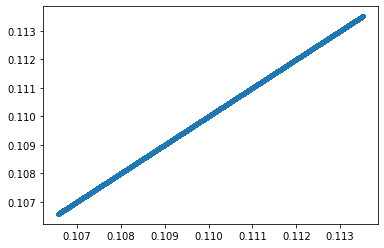

In [30]:
plt.plot(dt.time,dt.mag,'.')
plt.show()


In [99]:
# I think the best is to use the column indexs
def read_lc3(flpath,data_dict,header_nrows,delim_whitespace):
    
    '''Function to read the lc from the data
    
    Input:
    
    flpath: the location of the file
    
    data_dict: dictionary with the keys ('time','mag','mag_err','flux','flux_err','filters')
               the user provides the values corresponding to the keys
               e.g {'time':1}, were 1 is the time column index
               
    brightness_unit: Units used to measure the brightness
                     can either be 'flux' or 'mags'
                     
    header_nrows: The number of rows the header covers
    
    delim_whitespace: True when the data is not separated by a comma, false otherwise
               
   Output:
   
   standardized pandas dataframe with lc data'''
    
    
    # Reading-in the data
    data = pd.read_csv(flpath,skiprows=header_nrows,delim_whitespace=delim_whitespace,header=None)
    
    
    # ==================Magnitudes==================================
    # ==============================================================
    ID = data.iloc[:,data_dict['id']]
    if 'mag' in data_dict.keys(): 
        
        
        # ============MUtliple Mag columns=========================
        
        # The case of multiple brightness columns        
        if type(data_dict['mag']) == list:
            
            # Separatting the columns as per input dictionary
            time = data.iloc[:,data_dict['time']]; mag1 = data.iloc[:,data_dict['mag'][0]];
            mag2 = data.iloc[:,data_dict['mag'][1]]
            
            # Case where there are brightness error columns
            if 'mag_err' in data_dict.keys():                
                
                mag_error = data.iloc[:,data_dict['mag_err']]
                # Creating a new dictionary for the columns above separate data
                standard_data = {'ID':ID,'time':time,'mag1':mag1,'mag2':mag2,'mag_error':mag_error}
                
            # Case were there are no error columns
            else:
                
                standard_data = {'ID':ID,'time':time,'mag1':mag1,'mag2':mag2}
                           
        
        
                
        # ============Column with Mag_filters and errors==========================
        
        # Including filters in dataframe
        elif 'filters'in data_dict.keys() and 'mag_err' in data_dict.keys():
            
            # Separatting the columns as per input dictionary
            time = data.iloc[:,data_dict['time']]; mag = data.iloc[:,data_dict['mag']];
            mag_error = data.iloc[:,data_dict['mag_err']]

            filters = data.iloc[:,data_dict['filters']]
            standard_data = {'ID':ID,'time':time,'mag':mag,'mag_error':mag_error,'filters':filters}
            
        elif 'filters' in data_dict.keys():
            
            # Separatting the columns as per input dictionary
            time = data.iloc[:,data_dict['time']]; mag = data.iloc[:,data_dict['mag']];
    

            filters = data.iloc[:,data_dict['filters']]
            standard_data = {'ID':ID,'time':time,'mag':mag,'filters':filters}
            
            
            
            
        #=================Single Mag Column with and with errors============================
        
        # Case of single brightness columns    
        else:    
            
            
            # Separatting the columns as per input dictionary
            time = data.iloc[:,data_dict['time']]; mag = data.iloc[:,data_dict['mag']]; 
            
            if 'mag_err' in data_dict.keys():
                
                
                mag_error = data.iloc[:,data_dict['mag_err']]
                # Creating a new dictionary for the columns above separate data
                standard_data = {'ID':ID,'time':time,'mag':mag,'mag_error':mag_error}
                
            else:
                
                standard_data = {'ID':ID,'time':time,'mag':mag}
                
                
#-----------------------------------------------------------------------------------------------------------------                
            
#`````````````````````````````````````````````````````````````````````````````````````````````````````````````````      
#============================================Fluxes===============================================================
#=================================================================================================================
#`````````````````````````````````````````````````````````````````````````````````````````````````````````````````
        
    else:
        
        
        
                # ============MUtliple Mag columns=========================
        
        # The case of multiple brightness columns        
        if type(data_dict['flux']) == list:
            
            # Separatting the columns as per input dictionary
            time = data.iloc[:,data_dict['time']]; flux1 = data.iloc[:,data_dict['flux'][0]];
            flux2 = data.iloc[:,data_dict['flux'][1]]
            
            # Case where there are brightness error columns
            if 'flux_err' in data_dict.keys():                
                
                flux_error = data.iloc[:,data_dict['flux_err']]
                # Creating a new dictionary for the columns above separate data
                standard_data = {'ID':ID,'time':time,'flux1':flux1,'flux2':flux2,'flux_error':flux_error}
                
            # Case were there are no error columns
            else:
                
                standard_data = {'ID':ID,'time':time,'flux1':flux1,'flux2':flux2}
                           
        
        
                
        # ============Column with Mag_filters and errors==========================
        
        # Including filters in dataframe
        elif 'filters'in data_dict.keys() and 'flux_err' in data_dict.keys():
            
            # Separatting the columns as per input dictionary
            time = data.iloc[:,data_dict['time']]; flux = data.iloc[:,data_dict['flux']];
            flux_error = data.iloc[:,data_dict['flux_err']]

            filters = data.iloc[:,data_dict['filters']]
            standard_data = {'ID':ID,'time':time,'flux':flux,'flux_error':flux_error,'filters':filters}
            
        elif 'filters' in data_dict.keys():
            
            # Separatting the columns as per input dictionary
            time = data.iloc[:,data_dict['time']]; flux = data.iloc[:,data_dict['flux']];
    

            filters = data.iloc[:,data_dict['filters']]
            standard_data = {'ID':ID,'time':time,'flux':flux,'filters':filters}
            
            
            
            
        #=================Single Mag Column with and with errors============================
        
        # Case of single brightness columns    
        else:    
            
            
            # Separatting the columns as per input dictionary
            time = data.iloc[:,data_dict['time']]; flux = data.iloc[:,data_dict['flux']]; 
            
            if 'flux_err' in data_dict.keys():
                
                
                flux_error = data.iloc[:,data_dict['flux_err']]
                # Creating a new dictionary for the columns above separate data
                standard_data = {'ID':ID,'time':time,'flux':flux,'flux_error':flux_error}
                
            else:
                
                standard_data = {'ID':ID,'time':time,'flux':flux}
        
        
        
#         # Separatting the columns as per input dictionary
#         ID = data.iloc[:,data_dict['id']]; time = data.iloc[:,data_dict['time']]; 
#         flux = data.iloc[:,data_dict['flux']]; flux_error = data.iloc[:,data_dict['flux_err']];
    
#         standard_data = {'ID':ID,'time':time,'flux':flux,'flux_error':flux_error}
        
#         # Including filters in the dataframe
#         if 'filters' in data_dict.keys():
            
#             filters = data.iloc[:,data_dict['filters']]
#             standard_data = {'ID':ID,'time':time,'flux':flux,'flux_error':flux_error,'filters':filters}
            
    
    
    
    return pd.DataFrame.from_dict(standard_data)

In [102]:
path = '/home/malema/Desktop/Malema_UWC_Work/Data/20121012_02331333_O_CrabNebula_E.dat'

dt=read_lc3(flpath=url,data_dict={'time':1,'flux':[2,3],'flux_err':0,'id':3},delim_whitespace=True,header_nrows=2)

In [103]:
dt

,ID,time,flux1,flux2,flux_error
0,-0.102021,0.106574,0.000082,-0.102021,56212
1,-0.108044,0.106574,0.000017,-0.108044,56212
2,-0.094419,0.106574,0.000017,-0.094419,56212
3,-0.101473,0.106574,0.000050,-0.101473,56212
4,-0.103084,0.106574,0.000050,-0.103084,56212
...,...,...,...,...,...
5991389,-0.102278,0.113509,0.000017,-0.102278,56212
5991390,-0.099830,0.113509,0.000082,-0.099830,56212
5991391,-0.108591,0.113509,-0.000015,-0.108591,56212
5991392,-0.102246,0.113509,-0.000015,-0.102246,56212


In [40]:
type([1,2])

list